In [10]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
import sys
import os

Performing PCA with an Undercomplete Linear Autoencoder

If the autoencoder uses only linear activations and the cost function is the Mean Squared Error (MSE), then it can be shown that it ends up performing Principal Component Analysis.

Projection of 3D dataset to 2D

Now, build 3D dataset.

In [2]:
import numpy as np
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [3]:
#data normalization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [4]:
import tensorflow as tf

In [5]:
n_inputs = 3    #3D inputs
n_hidden = 2    #2D codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))    #MSE
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


Now, we will train the model on the training set, and use it to encode the test set.

In [6]:
n_iterations = 1000
codings = hidden     #output of the hidden layer

with tf.Session() as sess:
    init.run()
    for iterations in range(n_iterations):
        training_op.run(feed_dict = {X : X_train})    #no labels (unsupervised)
    codings_val = codings.eval(feed_dict = {X : X_test})

Stacked Autoencoders

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Now, we will build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

In [8]:
reset_graph()

from functools import partial

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150    #codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer()    #He initialization
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation = tf.nn.elu, kernel_initializer = he_init, kernel_regularizer = l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation = None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now, we will train this model (unsupervised training).

In [11]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end = "")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict = {X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

0 Train MSE: 0.020302366
1 Train MSE: 0.011643217
2 Train MSE: 0.010225878
3 Train MSE: 0.009900047
4 Train MSE: 0.01037747


The below function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction.

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [13]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict = {X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [15]:
def plot_image(image, shape = [28, 28]):
    plt.imshow(image.reshape(shape), cmap = "Greys", interpolation = "nearest")
    plt.axis("off")

In [16]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()    #make the minimum == 0, so the padding looks white
    w, h = images.shape[1:]
    image = np.zeros(((w + pad) * n_rows + pad, (h + pad) * n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap = "Greys", interpolation = "nearest")
    plt.axis("off")

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


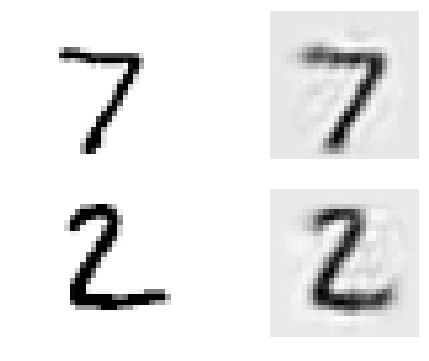

In [18]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")

Tying weights

It is common to tie the weights of the encoder and the decoder (weights_decoder = tf.transpose(weights_encoder)). 

Unfortunately, this makes it impossible (or very tricky) to use the tf.layers.dense() function, so we need to build the Autoencoder manually.

In [19]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150    #codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [20]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype = tf.float32, name = "weights1")
weights2 = tf.Variable(weights2_init, dtype = tf.float32, name = "weights2")
weights3 = tf.transpose(weights2, name = "weights3")    #tied weights, not a variable
weights4 = tf.transpose(weights1, name = "weights4")    #tied weights, not a variable

biases1 = tf.Variable(tf.zeros(n_hidden1), name = "biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name = "biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name = "biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name = "biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end = "")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict = {X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.01506695
1 Train MSE: 0.016488738
2 Train MSE: 0.017375927
3 Train MSE: 0.016878325
4 Train MSE: 0.015587717


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


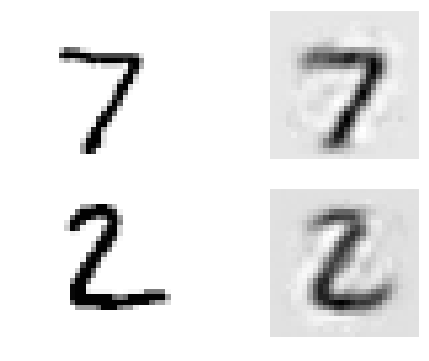

In [22]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

Training one Autoencoder at a time in multiple graphs

There are many ways to train one Autoencoder at a time.

The first approach is to train each Autoencoder using a different graph, then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

Now, we will create a function that will train one autoencoder and return the transformed training set (i.e., the output of the hidden layer) and the model parameters.

In [28]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size, learning_rate = 0.01, l2_reg = 0.0005, seed = 42,
                      hidden_activation = tf.nn.elu, output_activation = tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape = [None, n_inputs])
        
        my_dense_layer = partial(tf.layers.dense, kernel_initializer = tf.contrib.layers.variance_scaling_initializer(),
                                 kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation = hidden_activation, name = "hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation = output_activation, name = "outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        
        with tf.Session(graph = graph) as sess:
            init.run()
            for epoch in range(n_epochs):
                n_batches = len(X_train) // batch_size
                for iteration in range(n_batches):
                    print("\r{}%".format(100 * iteration // n_batches), end = "")
                    sys.stdout.flush()
                    indices = rnd.permutation(len(X_train))[:batch_size]
                    X_batch = X_train[indices]
                    sess.run(training_op, feed_dict = {X: X_batch})
                loss_train = reconstruction_loss.eval(feed_dict = {X: X_batch})
                print("\r{}".format(epoch), "Train MSE:", loss_train)
            params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
            hidden_val = hidden.eval(feed_dict = {X: X_train})
            return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Now, we will train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output.

In [29]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons = 300, n_epochs = 4, batch_size = 150,
                                                  output_activation = None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons = 150, n_epochs = 4, batch_size = 150)

0 Train MSE: 0.018517934
1 Train MSE: 0.018682716
2 Train MSE: 0.018467715
3 Train MSE: 0.019231727
0 Train MSE: 0.0042361096
1 Train MSE: 0.004832683
2 Train MSE: 0.0046687485
3 Train MSE: 0.00440391


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained.

In [30]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

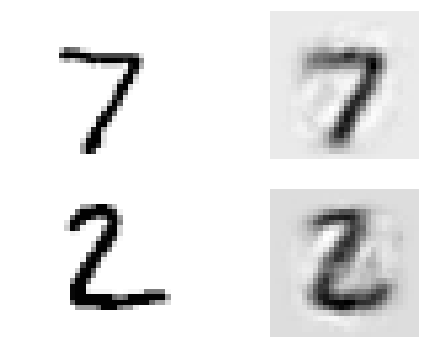

In [31]:
show_reconstructed_digits(X, outputs)

Training one Autoencoder at a time in a single graph

Another approach is to use a single graph.

To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (ie. the first Autoencoder) and phase 2 trains the two middle layers (ie. the second Autoencoder).

In [32]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150    #codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype = tf.float32, name = "weights1")
weights2 = tf.Variable(weights2_init, dtype = tf.float32, name = "weights2")
weights3 = tf.Variable(weights3_init, dtype = tf.float32, name = "weights3")
weights4 = tf.Variable(weights4_init, dtype = tf.float32, name = "weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name = "biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name = "biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name = "biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name = "biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

In [33]:
with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4     #bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list = train_vars)    #freeze hidden1
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end = "")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict = {X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict = {X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict = {X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.0074068652
1 Train MSE: 0.007828818
2 Train MSE: 0.007728095
3 Train MSE: 0.0074090054
Training phase #2
0 Train MSE: 0.3257826
1 Train MSE: 0.005739537
2 Train MSE: 0.0029418443
3 Train MSE: 0.0024437667
Test MSE: 0.009802573


Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs.

Now, we will plot two random digits and their reconstructions.

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


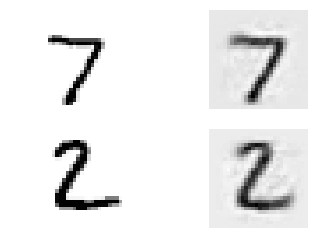

In [35]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape = [28, 28]):
    plt.imshow(image.reshape(shape), cmap = "Greys", interpolation = "nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

Visualizing the extracted features

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


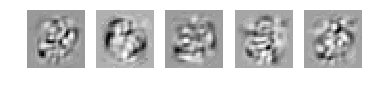

In [36]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

plt.show()

Unsupervised Pretraining using Stacked Autoencoders

In [37]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
y = tf.placeholder(tf.int32, shape = [None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype = tf.float32, name = "weights1")
weights2 = tf.Variable(weights2_init, dtype = tf.float32, name = "weights2")
weights3 = tf.Variable(weights3_init, dtype = tf.float32, name = "weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name = "biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name = "biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name = "biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.cast(tf.nn.in_top_k(logits, y, 1), tf.float32)
accuracy = tf.reduce_mean(correct)

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Regular training

In [38]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict = {X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict = {X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict = {X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.94666666 Test accuracy: 0.907
1 Train accuracy: 0.93333334 Test accuracy: 0.9252
2 Train accuracy: 0.93333334 Test accuracy: 0.9373
3 Train accuracy: 0.98 Test accuracy: 0.9442


Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This prevents the autoencoder from trivially copying its inputs to its outputs, so it ends up having to find patterns in the data.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched off inputs, just like in dropout.

Using Gaussian noise;

In [40]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150    #codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
noise_level = 1.0

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation = tf.nn.relu, name = "hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu, name = "hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation = tf.nn.relu, name = "hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name = "outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))    #MSE

In [41]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict = {X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.043684468
1 Train MSE: 0.044944283
2 Train MSE: 0.045092955
3 Train MSE: 0.042796224
4 Train MSE: 0.04287088
5 Train MSE: 0.04454955
6 Train MSE: 0.041695315
79% Train MSE: 0.044256493
8 Train MSE: 0.045652304
9 Train MSE: 0.042850543


Using Dropout; more common

In [43]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150    #codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape = (), name = 'training')

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training = training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation = tf.nn.relu, name = "hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu, name = "hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation = tf.nn.relu, name = "hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name = "outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))    #MSE

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict = {X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.030222915
1 Train MSE: 0.02716258
2 Train MSE: 0.025454944
3 Train MSE: 0.026437597
4 Train MSE: 0.023596678
5 Train MSE: 0.02282883
6 Train MSE: 0.024043314
7 Train MSE: 0.023618218
8 Train MSE: 0.023579607
9 Train MSE: 0.022849403


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


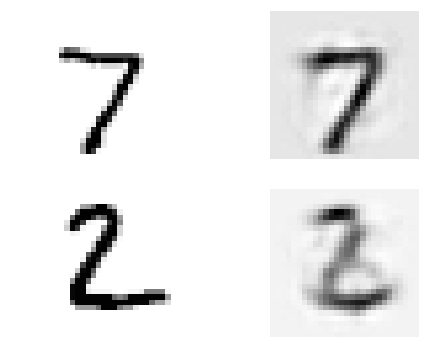

In [46]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

Sparse Autoencoder

In [47]:
reset_graph()

n_inputs = 28*28
n_hidden1 = 1000    #sparse codings
n_outputs = n_inputs

In [48]:
# Kullback Leibler divergence
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape = [None, n_inputs])

hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1, axis = 0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))    #MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [49]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss],
                                                                        feed_dict = {X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val,
              "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.13849652 	Sparsity loss: 0.19226234 	Total loss: 0.176949
1 Train MSE: 0.059294574 	Sparsity loss: 0.038990766 	Total loss: 0.067092724
2 Train MSE: 0.051892526 	Sparsity loss: 0.27790207 	Total loss: 0.10747294
3 Train MSE: 0.047694795 	Sparsity loss: 0.028206684 	Total loss: 0.053336132
4 Train MSE: 0.046148617 	Sparsity loss: 0.20140159 	Total loss: 0.08642894
5 Train MSE: 0.040703077 	Sparsity loss: 0.21758282 	Total loss: 0.08421964
6 Train MSE: 0.03868208 	Sparsity loss: 0.14870587 	Total loss: 0.06842326
7 Train MSE: 0.036804788 	Sparsity loss: 0.039616786 	Total loss: 0.044728145
8 Train MSE: 0.033982385 	Sparsity loss: 0.038040016 	Total loss: 0.04159039
9 Train MSE: 0.02993908 	Sparsity loss: 0.054716628 	Total loss: 0.040882405
10 Train MSE: 0.029206643 	Sparsity loss: 0.26570264 	Total loss: 0.08234717
11 Train MSE: 0.026094545 	Sparsity loss: 0.21701992 	Total loss: 0.069498524
12 Train MSE: 0.024054186 	Sparsity loss: 0.03956054 	Total loss: 0.031966295
13 

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


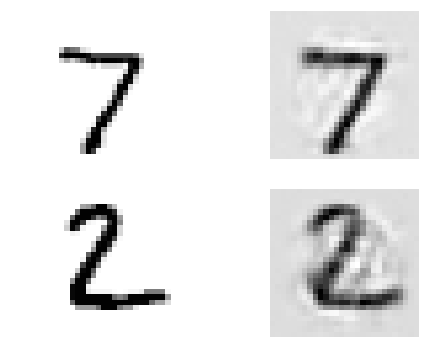

In [50]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

Variational Autoencoder

In [51]:
reset_graph()

from functools import partial

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20    #codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(tf.layers.dense, activation = tf.nn.elu, kernel_initializer = initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation = None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation = None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype = tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation = None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = X, logits = logits)
reconstruction_loss = tf.reduce_sum(xentropy)

eps = 1e-10     #smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(tf.square(hidden3_sigma) + tf.square(hidden3_mean) - 1 - tf.log(eps + tf.square(hidden3_sigma)))

loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [52]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end = "")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss],
                                                                      feed_dict = {X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val,
              "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 33016.66 	Reconstruction loss: 27020.271 	Latent loss: 5996.3877
1 Train total loss: 34717.66 	Reconstruction loss: 25899.926 	Latent loss: 8817.734
2 Train total loss: 26549.219 	Reconstruction loss: 21659.855 	Latent loss: 4889.363
3 Train total loss: 21738.217 	Reconstruction loss: 18590.555 	Latent loss: 3147.662
4 Train total loss: 20854.191 	Reconstruction loss: 17953.258 	Latent loss: 2900.9336
5 Train total loss: 21059.09 	Reconstruction loss: 18050.514 	Latent loss: 3008.5757
6 Train total loss: 19164.043 	Reconstruction loss: 16320.664 	Latent loss: 2843.38
7 Train total loss: 17970.008 	Reconstruction loss: 15064.506 	Latent loss: 2905.501
8 Train total loss: 17843.7 	Reconstruction loss: 14951.9 	Latent loss: 2891.7986
9 Train total loss: 16704.94 	Reconstruction loss: 13688.333 	Latent loss: 3016.6064
10 Train total loss: 16600.93 	Reconstruction loss: 13543.409 	Latent loss: 3057.5215
11 Train total loss: 16872.088 	Reconstruction loss: 13850.982 	Late

Generating digits

Now, we will use this variational autoencoder to generate images that look like handwritten digits.

We need to do is train the model, then sample random codings from a Gaussian distribution and decode them.

In [53]:
import numpy as np

n_digits = 60
n_epochs = 75
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end = "")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss],
                                                                      feed_dict = {X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val,
              "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")
    
    codings_rnd = np.random.normal(size = [n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict = {hidden3: codings_rnd})

0 Train total loss: 31102.291 	Reconstruction loss: 24958.941 	Latent loss: 6143.35
1 Train total loss: 28777.588 	Reconstruction loss: 23376.793 	Latent loss: 5400.795
2 Train total loss: 24268.324 	Reconstruction loss: 21689.402 	Latent loss: 2578.921
3 Train total loss: 23644.428 	Reconstruction loss: 20386.447 	Latent loss: 3257.9805
4 Train total loss: 19530.55 	Reconstruction loss: 16818.324 	Latent loss: 2712.2258
5 Train total loss: 18597.32 	Reconstruction loss: 15670.705 	Latent loss: 2926.6157
6 Train total loss: 18103.113 	Reconstruction loss: 15001.628 	Latent loss: 3101.4846
7 Train total loss: 17457.916 	Reconstruction loss: 14325.611 	Latent loss: 3132.3047
8 Train total loss: 16278.554 	Reconstruction loss: 13099.473 	Latent loss: 3179.0813
9 Train total loss: 17068.0 	Reconstruction loss: 13890.867 	Latent loss: 3177.1323
10 Train total loss: 16446.283 	Reconstruction loss: 13136.396 	Latent loss: 3309.8867
11 Train total loss: 16244.844 	Reconstruction loss: 13033.19

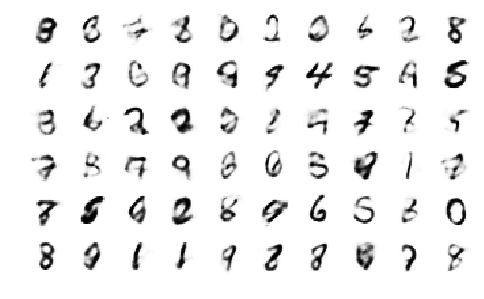

In [54]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])